# Mirnov coils
A Mirnov coil is a simple multi-turn loop of wire that measures the rate of change of magnetic field in the direction perpendicular to the plane of the loop via Faraday-Lenz law in electromagnetism. A signal can be registered either because the field strength is varying in time or there is a spatially varying magnetic field moving relative to the coil.

The location of mirnov coils are shown in the following figure:

![Mirnov coils](images/mirnov_coil_location.png)

## Use of Mirnov coils in MHD modes
A variety of plasma instabilities, such as NTMs, ideal MHD modes and chirping fast particle modes, can be identified by their characteristic time traces on a Fourier transform spectrogram of a Mirnov coil signal.


In [32]:
import zarr
import zarr.storage
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import stft

In [2]:
shot_id = 23447
endpoint="https://s3.echo.stfc.ac.uk"

In [34]:
fs = fsspec.filesystem(
    protocol='simplecache',
    target_protocol="s3",
    target_options=dict(anon=True, endpoint_url=endpoint)
)

url = f"s3://mast/level2/shots/{shot_id}.zarr"
store = zarr.storage.FSStore(fs=fs, url=url)

In [37]:
root = zarr.open_group(store, mode='r')

# List all variables/groups at the root level
print("Available variables/groups at root:")
for key in root:
    print(key)

Available variables/groups at root:
charge_exchange
equilibrium
gas_injection
magnetics
pf_active
pulse_schedule
soft_x_rays
spectrometer_visible
summary
thomson_scattering


In [38]:
root['equilibrium']

<zarr.hierarchy.Group '/equilibrium' read-only>

In [39]:
mirnov = xr.open_zarr(store, group="magnetics")
mirnov

<xarray.Dataset> Size: 32MB
Dimensions:                                   (b_field_pol_probe_cc_channel: 5,
                                               time_mirnov: 261200,
                                               b_field_pol_probe_ccbv_channel: 40,
                                               time: 2612,
                                               b_field_pol_probe_obr_channel: 18,
                                               b_field_pol_probe_obv_channel: 18,
                                               b_field_pol_probe_omv_channel: 3,
                                               b_field_tor_probe_cc_channel: 3,
                                               b_field_tor_probe_saddle_field_channel: 12,
                                               time_saddle: 26120,
                                               b_field_tor_probe_saddle_voltage_channel: 12,
                                               flux_loop_channel: 15)
Coordinates:
  * b_field_pol_probe_cc_channel              (b_field_pol_probe_cc_channel) <U13 260B ...
  * b_field_pol_probe_ccbv_channel            (b_field_pol_probe_ccbv_channel) <U10 2kB ...
  * b_field_pol_probe_obr_channel             (b_field_pol_probe_obr_channel) <U9 648B ...
  * b_field_pol_probe_obv_channel             (b_field_pol_probe_obv_channel) <U9 648B ...
  * b_field_pol_probe_omv_channel             (b_field_pol_probe_omv_channel) <U11 132B ...
  * b_field_tor_probe_cc_channel              (b_field_tor_probe_cc_channel) <U13 156B ...
  * b_field_tor_probe_saddle_field_channel    (b_field_tor_probe_saddle_field_channel) <U11 528B ...
  * b_field_tor_probe_saddle_voltage_channel  (b_field_tor_probe_saddle_voltage_channel) <U15 720B ...
  * flux_loop_channel                         (flux_loop_channel) <U12 720B '...
  * time                                      (time) float64 21kB -0.099 ... ...
  * time_mirnov                               (time_mirnov) float64 2MB -0.09...
  * time_saddle                               (time_saddle) float64 209kB -0....
Data variables:
    b_field_pol_probe_cc_field                (b_field_pol_probe_cc_channel, time_mirnov) float64 10MB ...
    b_field_pol_probe_ccbv_field              (b_field_pol_probe_ccbv_channel, time) float64 836kB ...
    b_field_pol_probe_obr_field               (b_field_pol_probe_obr_channel, time) float64 376kB ...
    b_field_pol_probe_obv_field               (b_field_pol_probe_obv_channel, time) float64 376kB ...
    b_field_pol_probe_omv_voltage             (b_field_pol_probe_omv_channel, time_mirnov) float64 6MB ...
    b_field_tor_probe_cc_field                (b_field_tor_probe_cc_channel, time_mirnov) float64 6MB ...
    b_field_tor_probe_saddle_field            (b_field_tor_probe_saddle_field_channel, time_saddle) float64 3MB ...
    b_field_tor_probe_saddle_voltage          (b_field_tor_probe_saddle_voltage_channel, time_saddle) float64 3MB ...
    flux_loop_flux                            (flux_loop_channel, time) float64 313kB ...
    ip                                        (time) float64 21kB ...
Attributes:
    description:  
    imas:         magnetics
    label:        Plasma Current
    name:         magnetics
    uda_name:     AMC_PLASMA CURRENT
    units:        A

Each data variable denote the magnetic field signal from a Mirnov coil at different locations.

## Visualising omaha_l5c

In [41]:
ds = mirnov['b_field_pol_probe_omv_voltage'].isel(b_field_pol_probe_omv_channel=1)

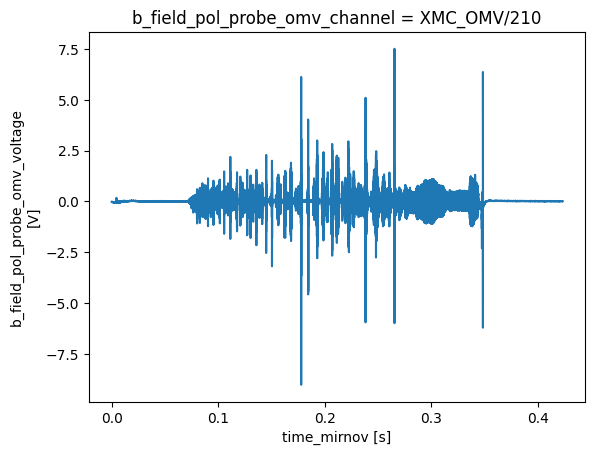

In [43]:
ds.plot()

## Fourier transform spectrogram of magnetic fluctuations (measured in Tesla) from a Mirnov coil

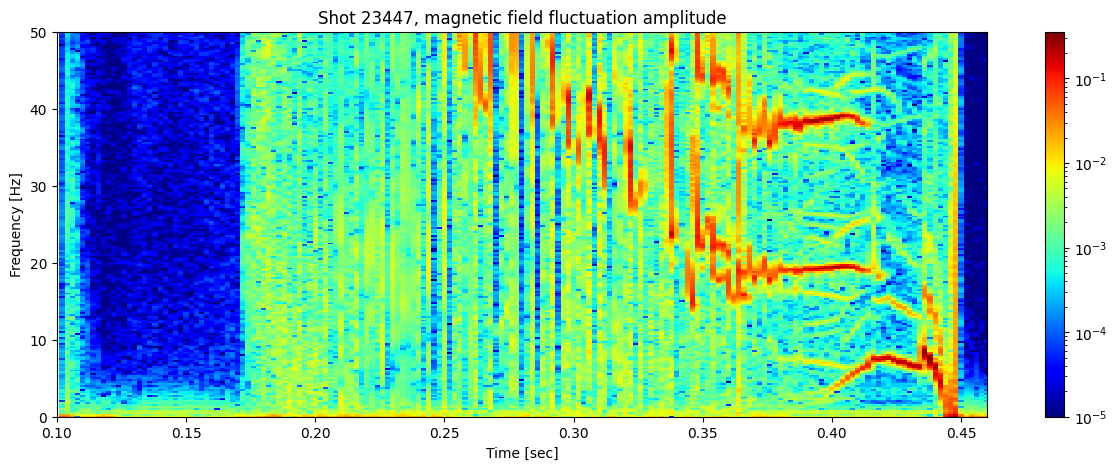

In [58]:
nperseg = 2000  # Number of points per segment
nfft = 2000  # Number of FFT points

# Compute the Short-Time Fourier Transform (STFT)
sample_rate = 1/(ds.time_mirnov[1] - ds.time_mirnov[0])
f, t, Zxx = stft(ds, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

fig, ax = plt.subplots(figsize=(15, 5))
cax = ax.pcolormesh(t, f/1000, np.abs(Zxx), shading='nearest', cmap='jet', norm=LogNorm(vmin=1e-5))
ax.set_ylim(0, 50)
ax.set_title(f'Shot {shot_id}, magnetic field fluctuation amplitude')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
ax.set_xlim(0.1, 0.46)
plt.colorbar(cax, ax=ax)

A much better picture plotted in a Phd thesis is shown below:

![Fourier transform spectrogram](images/mirnov_coil_fft.png)

This plot represents the frequency spectrum of magnetic fluctuations (measured in Tesla) recorded using diagnostics such as Mirnov coils during a plasma discharge in a tokamak (e.g., MAST or JET). The spectrogram is a collection of multiple FFTs (Fast Fourier Transforms) performed over successive short time intervals during the plasma shot. The axes are:

* X-axis: Time (in seconds).
* Y-axis: Frequency (in kHz).
* Color: Logarithmic scale of magnetic field fluctuation amplitude (log₁₀|B|) in Tesla, where warmer colors (red/orange) indicate stronger signals and cooler colors (blue) indicate weaker signals.

where warmer colors (red/orange) indicate stronger signals and cooler colors (blue) indicate weaker signals.

* Chirping (Fishbones): The frequency changes ("chirps") over a short time scale.
* 2/1 NTM (Neoclassical Tearing Mode): Characterised as low-frequency (often below ~20 kHz) instability.
*  Constant Frequency (Long-Lived Modes - LLMs): Frequency stays constant over extended time durations.

These distinct patterns can be used to identify different types of plasma instabilities and to study their evolution over time. There are several non Machine learning techniques to separate these modes.

* Thresholding: A simple thresholding technique can be used to identify the presence of a mode. For example, if the amplitude of the signal exceeds a certain threshold, it can be classified as a mode.
* Bandpass filter: A bandpass filter can be used to isolate the frequency range of interest. This can help to remove noise and other unwanted signals from the data.
* Ridge detection: Ridge detection algorithms can be used to identify the presence of ridges in the spectrogram. This can help to identify the frequency and time of the mode.
* Wavelet transform: The wavelet transform can be used to identify the presence of modes in the spectrogram. This can help to identify the frequency and time of the mode.
* Hough or Radon transform: The Hough or Radon transform can be used to identify the presence of lines in the spectrogram. This can help to identify the frequency and time of the mode.
* Peak and contour detection: Peak and contour detection algorithms can be used to identify the presence of peaks in the spectrogram. This can help to identify the frequency and time of the mode.
* Connected component analysis: Connected component analysis can be used to identify the presence of connected components in the spectrogram. This can help to identify the frequency and time of the mode.
* Spectral kurtosis: Spectral kurtosis can be used to identify the presence of modes in the spectrogram. This can help to identify the frequency and time of the mode.
* temporal averaging: Temporal averaging can be used to identify the presence of modes in the spectrogram. This can help to identify the frequency and time of the mode.
* Spectral entropy: Spectral entropy can be used to identify the presence of modes in the spectrogram. This can help to identify the frequency and time of the mode.
